In [1]:
# alocação de espaço CPU x GPU

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# warnings
import warnings
warnings.filterwarnings("ignore")

### Grupos Telegram

Para este trabalho de classificação, usaremos uma base de quase 8 mil grupos do telegram, dos quais foram extraídas as cinco primeiras mensagens. Nosso objetivo é, apenas com essa informação e a respectiva classificação em grupo bolsonarista e não bolsonarista, construir um modelo que identifique com a maior acurácia possível se o grupo é bolsonarista ou não.

In [3]:
# import grupos telegram

import pandas as pd

df_telegram_cru = pd.read_csv('grupos_com_mensagens_telegram.csv').drop('chat_id', axis=1)

df_telegram = df_telegram_cru.copy()
df_telegram[df_telegram.columns[3:]] = df_telegram[df_telegram.columns[3:]].astype(str)
df_telegram['mensagem'] = df_telegram[df_telegram.columns[3:]].agg(' '.join, axis=1)
df_telegram = df_telegram[['classe', 'mensagem']]
df_telegram.head(1)

,classe,mensagem
0,bolsonarista,EUA afirmam que Brasil será o próximo a inicia...


In [4]:
# classe por id
df_telegram.groupby(['classe']).count()

,mensagem
classe,
bolsonarista,2343
indefinido,344
não-bolsonarista,5199


Vamos considerar apenas bolsonaristas e não bolsonaristas neste estudo. Os bolsonaristas estarão identificados como "B" ou 1, e os não bolsonaristas, "NB" ou 0.

In [5]:
# base

base = df_telegram[df_telegram['classe'].isin(['bolsonarista', 'não-bolsonarista'])].copy()
base.loc[base['classe'] == 'bolsonarista', 'classificacao'] = 'B'
base.loc[base['classe'] == 'não-bolsonarista', 'classificacao'] = 'NB'

base = base[['mensagem', 'classificacao']]

base.head()

,mensagem,classificacao
0,EUA afirmam que Brasil será o próximo a inicia...,B
1,"Bom dia REPASSE O MÁXIMO POSSÍVEL, ASSIM MANTE...",B
2,Bom dia grupo Bom dia Oi Bom dia galera Boa no...,NB
3,Bom dia graça e a paz do senhor Jesus Cristo à...,NB
4,🤣🤣🤣 *LECH WALESA & LULA: DUAS PARTES DA MESMA ...,NB


#### Pré Processamento

In [6]:
# imports bibliotecas

import itertools
from collections import Counter
from numpy import prod
from math import log

import nltk
nltk.download('punkt')
from nltk import tokenize 
nltk.download('stopwords')
stops = nltk.corpus.stopwords.words('portuguese')

stops.remove('não')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tomcat2064\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomcat2064\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# pre processamento

def tokenizar(str_texto):
    return tokenize.word_tokenize(str_texto, language='portuguese')


def sem_stops(lst_palavras):
    return [p for p in lst_palavras if p not in stops]


def limpar(lista):
    return [i.lower() for i in lista if i.isalpha()]


def pre_processar(str_texto):
    return sem_stops(limpar(tokenizar(str_texto)))


def achatar(lista):
    return list(itertools.chain(*lista))

In [8]:
# corpus

base_dict = base.to_dict('records')
corpus = [(pre_processar(val['mensagem']), val['classificacao']) for val in base_dict]

In [9]:
# separacao texto e classificacoes

import numpy as np

matrix = np.array(corpus)
simple_texts = matrix[:, 0]
texts = np.array([' '.join(msg) for msg in simple_texts])

labels = matrix[:, 1]

#### Primeira Abordagem: Classificador Bayesiano Ingênuo

In [10]:
# vectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vetor = CountVectorizer()
X_texts = vetor.fit_transform(texts).toarray()

X_texts.shape

(7542, 23521)

In [11]:
# separacao treino-teste

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_texts, labels, test_size=0.3, stratify=labels, random_state=42)

In [12]:
X_train.shape

(5279, 23521)

In [13]:
X_test.shape

(2263, 23521)

In [14]:
# separacao treino-teste

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [15]:
# métricas - precisão, sensibilidade, f1
from sklearn.metrics import classification_report

predict_nb = model.predict(X_test)
classification_report(y_test, predict_nb)

'              precision    recall  f1-score   support\n\n           B       0.77      0.62      0.69       703\n          NB       0.84      0.92      0.88      1560\n\n    accuracy                           0.83      2263\n   macro avg       0.81      0.77      0.78      2263\nweighted avg       0.82      0.83      0.82      2263\n'

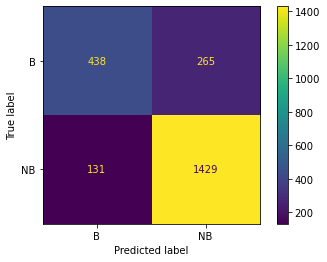

In [16]:
# matriz de confusão
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test)

In [17]:
# Para comparação posterior
X_test_nb = X_test.copy()
y_test_nb = y_test.copy()

#### Segunda Abordagem: Redes Neurais

In [18]:
# índice de palavras
vocab = set([word for text in simple_texts for word in text])
word_index = {word: e+1 for e, word in enumerate(vocab)}
vec_msg = np.array([[word_index[word] for word in text] for text in simple_texts], dtype=object)

In [19]:
# Codificação binária
def binarizer(matriz_int, dim=len(vocab)+1):
    binarized = np.zeros((len(matriz_int), dim))
    for e, vetor in enumerate(matriz_int):
        binarized[e, vetor] = 1.

    return binarized

vec_msg_bin = binarizer(vec_msg)

In [20]:
# Etiquetas: string -> boolean
labels_bin = labels.copy()

labels_bin[labels_bin == 'B'] = 1
labels_bin[labels_bin == 'NB'] = 0

labels_bin = labels_bin.astype(int)

In [21]:
# separacao treino-teste

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vec_msg_bin, labels_bin, test_size=0.3, 
                                                    stratify=labels_bin, random_state=42)

In [22]:
# Rede Neural

from keras import models 
from keras import layers

nn = models.Sequential() 
nn.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],))) 
nn.add(layers.Dense(32, activation='relu')) 
nn.add(layers.Dense(1, activation='sigmoid'))

nn.compile(optimizer='adam', 
           loss='binary_crossentropy', 
           metrics=['acc'])

neural_network = nn.fit(X_train, 
                        y_train, 
                        epochs=20, 
                        batch_size=512, 
                        validation_data=(X_test, y_test))

Epoch 1/20
11/11 [==============================] - 2s 58ms/step - loss: 0.6640 - acc: 0.7676 - val_loss: 0.6114 - val_acc: 0.8378
Epoch 2/20
11/11 [==============================] - 0s 31ms/step - loss: 0.5468 - acc: 0.8657 - val_loss: 0.5176 - val_acc: 0.8383
Epoch 3/20
11/11 [==============================] - 0s 30ms/step - loss: 0.4327 - acc: 0.8803 - val_loss: 0.4556 - val_acc: 0.8405
Epoch 4/20
11/11 [==============================] - 0s 30ms/step - loss: 0.3495 - acc: 0.8903 - val_loss: 0.4247 - val_acc: 0.8405
Epoch 5/20
11/11 [==============================] - 0s 31ms/step - loss: 0.2931 - acc: 0.9004 - val_loss: 0.4121 - val_acc: 0.8414
Epoch 6/20
11/11 [==============================] - 0s 31ms/step - loss: 0.2578 - acc: 0.9076 - val_loss: 0.4108 - val_acc: 0.8431
Epoch 7/20
11/11 [==============================] - 0s 31ms/step - loss: 0.2373 - acc: 0.9131 - val_loss: 0.4159 - val_acc: 0.8445
Epoch 8/20
11/11 [==============================] - 0s 33ms/step - loss: 0.2265 - a

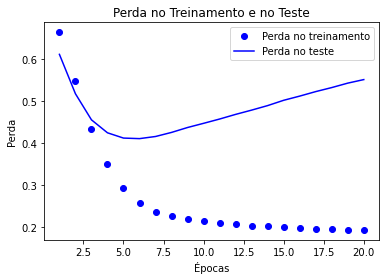

In [23]:
# Acompanhamento da função perda

import matplotlib.pyplot as plt

dict_neural_network = neural_network.history
loss = dict_neural_network['loss'] 
test_loss = dict_neural_network['val_loss']

acc = dict_neural_network['acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Perda no treinamento')  # “bo” = pontilhado azul
plt.plot(epochs, test_loss, 'b', label='Perda no teste')  # “b” = linha contínua azul
plt.title('Perda no Treinamento e no Teste') 
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

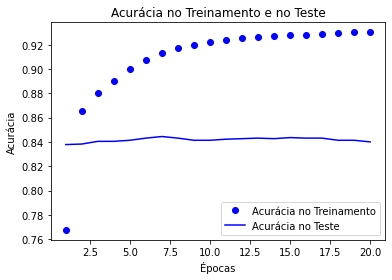

In [24]:
# Acompanhamento da função acurácia

plt.clf()

acc_train = dict_neural_network['acc'] 
acc_test = dict_neural_network['val_acc']

plt.plot(epochs, acc_train, 'bo', label='Acurácia no Treinamento') 
plt.plot(epochs, acc_test, 'b', label='Acurácia no Teste')
plt.title('Acurácia no Treinamento e no Teste') 
plt.xlabel('Épocas') 
plt.ylabel('Acurácia') 
plt.legend()

plt.show()

In [25]:
# Predicoes
nn_predict = nn.predict(X_test)
predicted_val = [round(val[0]) for val in nn_predict.tolist()]

71/71 [==============================] - 0s 2ms/step


In [26]:
# Predicoes comparáveis: 1 -> B e 0 -> NB
predicted_val_str = predicted_val.copy()
predicted_val_str = np.array(predicted_val_str).astype(object)

predicted_val_str[predicted_val_str == 1] = 'B'
predicted_val_str[predicted_val_str == 0] = 'NB'

y_test_str = y_test.copy()
y_test_str = y_test_str.astype(object)

y_test_str[y_test_str == 1] = 'B'
y_test_str[y_test_str == 0] = 'NB'

In [27]:
# métricas - precisão, sensibilidade, f1
print(classification_report(y_test_str, predicted_val_str))

              precision    recall  f1-score   support

           B       0.81      0.64      0.71       703
          NB       0.85      0.93      0.89      1560

    accuracy                           0.84      2263
   macro avg       0.83      0.78      0.80      2263
weighted avg       0.84      0.84      0.83      2263



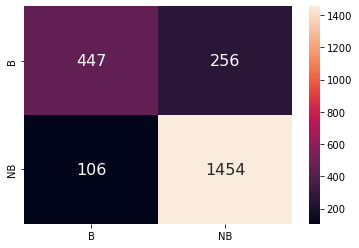

In [28]:
# matriz de confusão
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.metrics

cm = sklearn.metrics.confusion_matrix(y_test_str, predicted_val_str)
df_cm = pd.DataFrame(cm, range(2), range(2))
df_cm.columns = ['B', 'NB']
df_cm.rename(index={0: 'B', 1: 'NB'}, inplace=True)

sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

plt.show()

#### Comparação de perfomances: Classificador Bayesiano Ingênuo x Redes Neurais

In [29]:
# métricas - precisão, sensibilidade, f1 - Classificador Bayesiano Ingênuo
print(classification_report(y_test_nb, predict_nb))

              precision    recall  f1-score   support

           B       0.77      0.62      0.69       703
          NB       0.84      0.92      0.88      1560

    accuracy                           0.83      2263
   macro avg       0.81      0.77      0.78      2263
weighted avg       0.82      0.83      0.82      2263



In [30]:
# métricas - precisão, sensibilidade, f1 - Redes Neurais
print(classification_report(y_test_str, predicted_val_str))

              precision    recall  f1-score   support

           B       0.81      0.64      0.71       703
          NB       0.85      0.93      0.89      1560

    accuracy                           0.84      2263
   macro avg       0.83      0.78      0.80      2263
weighted avg       0.84      0.84      0.83      2263



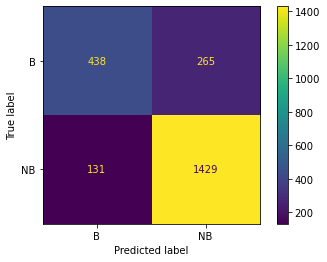

In [31]:
# matriz de confusão - Classificador Bayesiano Ingênuo
plot_confusion_matrix(model, X_test_nb, y_test_nb)

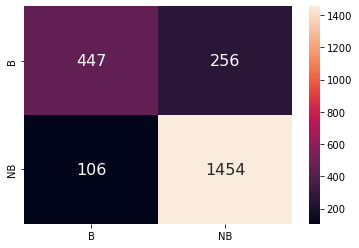

In [32]:
# matriz de confusão - Redes Neurais
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

plt.show()